In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [6]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/10/23 21:04:50 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/23 21:04:50 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/yamraj/Projects/mloops_projects/mloops_self_paced/03-training/mlruns/1', creation_time=1760720322046, experiment_id='1', last_update_time=1760720322046, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829625

/tmp/ipykernel_6110/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_6110/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


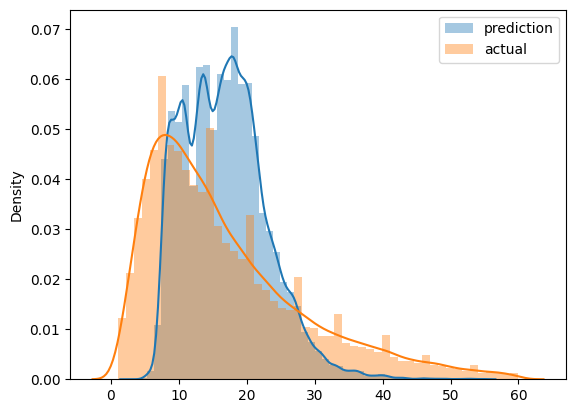

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('green_tripdata_2021-01.parquet')
df_val = read_dataframe('green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715198889101

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
from sklearn.metrics import mean_squared_error


In [19]:
pip install --upgrade scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [20]:
with mlflow.start_run():
  mlflow.set_tag("developer","cristian")
  mlflow.log_param("train-data-path","green_tripdata_2021-01.parquet")
  mlflow.log_param("valid-data-path","green_tripdata_2021-02.parquet")
  alpha=0.1
  
  mlflow.log_param("alpha",alpha)
  lr = Lasso(alpha)

  lr.fit(X_train, y_train)

  y_pred = lr.predict(X_val)

  rmse= mean_squared_error(y_val, y_pred)
  mlflow.log_metric("rmse",rmse)

In [27]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope


In [28]:
train=xgb.DMatrix(X_train, label=y_train)
valid=xgb.DMatrix(X_val, label=y_val)   

In [29]:
def objective(params):    
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50,
          )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred)

        mlflow.log_metric("rmse", rmse)
    return {'loss': rmse, 'status': STATUS_OK}

In [30]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:19:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.72308                          
[1]	validation-rmse:11.27199                          
[2]	validation-rmse:10.85669                          
[3]	validation-rmse:10.47595                          
[4]	validation-rmse:10.12643                          
[5]	validation-rmse:9.80683                           
[6]	validation-rmse:9.51491                           
[7]	validation-rmse:9.24836                           
[8]	validation-rmse:9.00530                           
[9]	validation-rmse:8.78413                           
[10]	validation-rmse:8.58290                          
[11]	validation-rmse:8.39999                          
[12]	validation-rmse:8.23445                          
[13]	validation-rmse:8.08414                          
[14]	validation-rmse:7.94877                          
[15]	validation-rmse:7.82551                          
[16]	validation-rmse:7.71334                          
[17]	validation-rmse:7.61206                          
[18]	valid

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:23:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.34190                                                       
[1]	validation-rmse:7.18166                                                       
[2]	validation-rmse:6.85043                                                       
[3]	validation-rmse:6.73943                                                       
[4]	validation-rmse:6.69594                                                       
[5]	validation-rmse:6.67190                                                       
[6]	validation-rmse:6.65697                                                       
[7]	validation-rmse:6.65148                                                       
[8]	validation-rmse:6.64600                                                       
[9]	validation-rmse:6.64233                                                       
[10]	validation-rmse:6.63929                                                      
[11]	validation-rmse:6.63481                                                      
[12]

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:26:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.95327                                                      
[1]	validation-rmse:9.94966                                                       
[2]	validation-rmse:9.15862                                                       
[3]	validation-rmse:8.54172                                                       
[4]	validation-rmse:8.06516                                                       
[5]	validation-rmse:7.69904                                                       
[6]	validation-rmse:7.42122                                                       
[7]	validation-rmse:7.20493                                                       
[8]	validation-rmse:7.04441                                                       
[9]	validation-rmse:6.92061                                                       
[10]	validation-rmse:6.82548                                                      
[11]	validation-rmse:6.75195                                                      
[12]

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:32:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.96103                                                      
[2]	validation-rmse:10.43908                                                      
[3]	validation-rmse:9.97856                                                       
[4]	validation-rmse:9.57140                                                       
[5]	validation-rmse:9.21656                                                       
[6]	validation-rmse:8.90571                                                       
[7]	validation-rmse:8.63277                                                       
[8]	validation-rmse:8.39442                                                       
[9]	validation-rmse:8.18781                                                       
[10]	validation-rmse:8.00914                                                      
[11]	validation-rmse:7.85258                                                      
[12]	validation-rmse:7.71682                                                      
[13]

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:35:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.98869                                                      
[1]	validation-rmse:10.01219                                                      
[2]	validation-rmse:9.24010                                                       
[3]	validation-rmse:8.63625                                                       
[4]	validation-rmse:8.16928                                                       
[5]	validation-rmse:7.80942                                                       
[6]	validation-rmse:7.53491                                                       
[7]	validation-rmse:7.32380                                                       
[8]	validation-rmse:7.16423                                                       
[9]	validation-rmse:7.04036                                                       
[10]	validation-rmse:6.94249                                                      
[11]	validation-rmse:6.86695                                                      
[12]

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:41:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.45797                                                      
[1]	validation-rmse:10.79731                                                      
[2]	validation-rmse:10.22147                                                      
[3]	validation-rmse:9.72151                                                       
[4]	validation-rmse:9.28918                                                       
[5]	validation-rmse:8.91671                                                       
[6]	validation-rmse:8.59675                                                       
[7]	validation-rmse:8.32273                                                       
[8]	validation-rmse:8.08884                                                       
[9]	validation-rmse:7.88969                                                       
[10]	validation-rmse:7.72021                                                      
[11]	validation-rmse:7.57615                                                      
[12]

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:44:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.93254                                                      
[1]	validation-rmse:9.91729                                                       
[2]	validation-rmse:9.12029                                                       
[3]	validation-rmse:8.50163                                                       
[4]	validation-rmse:8.02514                                                       
[5]	validation-rmse:7.66175                                                       
[6]	validation-rmse:7.38558                                                       
[7]	validation-rmse:7.17380                                                       
[8]	validation-rmse:7.01552                                                       
[9]	validation-rmse:6.89471                                                       
[10]	validation-rmse:6.80317                                                      
[11]	validation-rmse:6.73320                                                      
[12]

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:49:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.44383                                                      
[1]	validation-rmse:10.76908                                                      
[2]	validation-rmse:10.17962                                                      
[3]	validation-rmse:9.66547                                                       
[4]	validation-rmse:9.21868                                                       
[5]	validation-rmse:8.83083                                                       
[6]	validation-rmse:8.49772                                                       
[7]	validation-rmse:8.21150                                                       
[8]	validation-rmse:7.96587                                                       
[9]	validation-rmse:7.75632                                                       
[10]	validation-rmse:7.57815                                                      
[11]	validation-rmse:7.42547                                                      
[12]

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:58:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.18629                                                      
[1]	validation-rmse:8.84399                                                       
[2]	validation-rmse:7.98097                                                       
[3]	validation-rmse:7.43783                                                       
[4]	validation-rmse:7.09909                                                       
[5]	validation-rmse:6.89026                                                       
[6]	validation-rmse:6.75809                                                       
[7]	validation-rmse:6.67269                                                       
[8]	validation-rmse:6.61617                                                       
[9]	validation-rmse:6.57825                                                       
[10]	validation-rmse:6.54789                                                      
[11]	validation-rmse:6.52573                                                      
[12]

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:01:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.62547                                                       
[1]	validation-rmse:8.21661                                                       
[2]	validation-rmse:7.49040                                                       
[3]	validation-rmse:7.12066                                                       
[4]	validation-rmse:6.93455                                                       
[5]	validation-rmse:6.83142                                                       
[6]	validation-rmse:6.77118                                                       
[7]	validation-rmse:6.73874                                                       
[8]	validation-rmse:6.71803                                                       
[9]	validation-rmse:6.70531                                                       
[10]	validation-rmse:6.69001                                                      
[11]	validation-rmse:6.68271                                                      
[12]

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:06:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.66640                                                        
[1]	validation-rmse:6.59773                                                        
[2]	validation-rmse:6.57704                                                        
[3]	validation-rmse:6.57039                                                        
[4]	validation-rmse:6.56382                                                        
[5]	validation-rmse:6.55189                                                        
[6]	validation-rmse:6.54542                                                        
[7]	validation-rmse:6.53292                                                        
[8]	validation-rmse:6.52660                                                        
[9]	validation-rmse:6.51922                                                        
[10]	validation-rmse:6.51458                                                       
[11]	validation-rmse:6.50876                                                

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:07:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.52048                                                       
[1]	validation-rmse:10.90480                                                       
[2]	validation-rmse:10.35992                                                       
[3]	validation-rmse:9.87880                                                        
[4]	validation-rmse:9.45498                                                        
[5]	validation-rmse:9.08291                                                        
[6]	validation-rmse:8.75710                                                        
[7]	validation-rmse:8.47244                                                        
[8]	validation-rmse:8.22414                                                        
[9]	validation-rmse:8.00772                                                        
[10]	validation-rmse:7.82011                                                       
[11]	validation-rmse:7.65733                                                

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:13:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.77528                                                        
[1]	validation-rmse:8.33415                                                        
[2]	validation-rmse:7.51437                                                        
[3]	validation-rmse:7.06863                                                        
[4]	validation-rmse:6.82147                                                        
[5]	validation-rmse:6.68194                                                        
[6]	validation-rmse:6.59940                                                        
[7]	validation-rmse:6.54858                                                        
[8]	validation-rmse:6.51744                                                        
[9]	validation-rmse:6.49749                                                        
[10]	validation-rmse:6.48051                                                       
[11]	validation-rmse:6.46856                                                

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:16:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.01969                                                       
[1]	validation-rmse:10.05775                                                       
[2]	validation-rmse:9.28775                                                        
[3]	validation-rmse:8.67835                                                        
[4]	validation-rmse:8.19967                                                        
[5]	validation-rmse:7.82582                                                        
[6]	validation-rmse:7.53533                                                        
[7]	validation-rmse:7.31087                                                        
[8]	validation-rmse:7.13757                                                        
[9]	validation-rmse:7.00430                                                        
[10]	validation-rmse:6.90154                                                       
[11]	validation-rmse:6.82025                                                

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:22:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.48435                                                          
[1]	validation-rmse:7.18583                                                          
[2]	validation-rmse:6.77100                                                          
[3]	validation-rmse:6.62488                                                          
[4]	validation-rmse:6.56351                                                          
[5]	validation-rmse:6.53238                                                          
[6]	validation-rmse:6.51688                                                          
[7]	validation-rmse:6.50590                                                          
[8]	validation-rmse:6.49966                                                          
[9]	validation-rmse:6.49455                                                          
[10]	validation-rmse:6.49054                                                         
[11]	validation-rmse:6.48550                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:25:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.43450                                                         
[1]	validation-rmse:10.75246                                                         
[2]	validation-rmse:10.15791                                                         
[3]	validation-rmse:9.64172                                                          
[4]	validation-rmse:9.19499                                                          
[5]	validation-rmse:8.80969                                                          
[6]	validation-rmse:8.47809                                                          
[7]	validation-rmse:8.19368                                                          
[8]	validation-rmse:7.95066                                                          
[9]	validation-rmse:7.74278                                                          
[10]	validation-rmse:7.56567                                                         
[11]	validation-rmse:7.41559                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:33:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.47864                                                          
[1]	validation-rmse:6.81822                                                          
[2]	validation-rmse:6.70102                                                          
[3]	validation-rmse:6.66580                                                          
[4]	validation-rmse:6.65479                                                          
[5]	validation-rmse:6.64888                                                          
[6]	validation-rmse:6.64084                                                          
[7]	validation-rmse:6.63467                                                          
[8]	validation-rmse:6.62697                                                          
[9]	validation-rmse:6.62291                                                          
[10]	validation-rmse:6.61971                                                         
[11]	validation-rmse:6.61762                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:35:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.57431                                                         
[1]	validation-rmse:11.00253                                                         
[2]	validation-rmse:10.49227                                                         
[3]	validation-rmse:10.03810                                                         
[4]	validation-rmse:9.63473                                                          
[5]	validation-rmse:9.27768                                                          
[6]	validation-rmse:8.96232                                                          
[7]	validation-rmse:8.68445                                                          
[8]	validation-rmse:8.44011                                                          
[9]	validation-rmse:8.22550                                                          
[10]	validation-rmse:8.03762                                                         
[11]	validation-rmse:7.87337                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:44:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.08368                                                         
[1]	validation-rmse:10.16339                                                         
[2]	validation-rmse:9.41899                                                          
[3]	validation-rmse:8.82172                                                          
[4]	validation-rmse:8.34688                                                          
[5]	validation-rmse:7.97254                                                          
[6]	validation-rmse:7.67741                                                          
[7]	validation-rmse:7.44672                                                          
[8]	validation-rmse:7.26634                                                          
[9]	validation-rmse:7.12377                                                          
[10]	validation-rmse:7.01319                                                         
[11]	validation-rmse:6.92487                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:51:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.63209                                                         
[1]	validation-rmse:11.10710                                                         
[2]	validation-rmse:10.63337                                                         
[3]	validation-rmse:10.20731                                                         
[4]	validation-rmse:9.82444                                                          
[5]	validation-rmse:9.48112                                                          
[6]	validation-rmse:9.17322                                                          
[7]	validation-rmse:8.89911                                                          
[8]	validation-rmse:8.65399                                                          
[9]	validation-rmse:8.43689                                                          
[10]	validation-rmse:8.24293                                                         
[11]	validation-rmse:8.07153                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:55:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.57962                                                         
[1]	validation-rmse:9.39541                                                          
[2]	validation-rmse:8.55601                                                          
[3]	validation-rmse:7.96044                                                          
[4]	validation-rmse:7.55671                                                          
[5]	validation-rmse:7.28027                                                          
[6]	validation-rmse:7.08482                                                          
[7]	validation-rmse:6.95230                                                          
[8]	validation-rmse:6.85297                                                          
[9]	validation-rmse:6.78524                                                          
[10]	validation-rmse:6.73610                                                         
[11]	validation-rmse:6.69992                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:59:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77661                                                         
[1]	validation-rmse:11.36992                                                         
[2]	validation-rmse:10.99114                                                         
[3]	validation-rmse:10.63899                                                         
[4]	validation-rmse:10.31268                                                         
[5]	validation-rmse:10.00905                                                         
[6]	validation-rmse:9.72900                                                          
[7]	validation-rmse:9.46915                                                          
[8]	validation-rmse:9.22835                                                          
[9]	validation-rmse:9.00652                                                          
[10]	validation-rmse:8.80182                                                         
[11]	validation-rmse:8.61170                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:13:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.78650                                                         
[1]	validation-rmse:11.38826                                                         
[2]	validation-rmse:11.01623                                                         
[3]	validation-rmse:10.66978                                                         
[4]	validation-rmse:10.34814                                                         
[5]	validation-rmse:10.04810                                                         
[6]	validation-rmse:9.76996                                                          
[7]	validation-rmse:9.51136                                                          
[8]	validation-rmse:9.27201                                                          
[9]	validation-rmse:9.04923                                                          
[10]	validation-rmse:8.84414                                                         
[11]	validation-rmse:8.65378                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:27:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77141                                                         
[1]	validation-rmse:11.36165                                                         
[2]	validation-rmse:10.98262                                                         
[3]	validation-rmse:10.62806                                                         
[4]	validation-rmse:10.30030                                                         
[5]	validation-rmse:9.99614                                                          
[6]	validation-rmse:9.71820                                                          
[7]	validation-rmse:9.45669                                                          
[8]	validation-rmse:9.21933                                                          
[9]	validation-rmse:9.00160                                                          
[10]	validation-rmse:8.79836                                                         
[11]	validation-rmse:8.61182                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:43:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.24538                                                         
[1]	validation-rmse:10.43339                                                         
[2]	validation-rmse:9.75087                                                          
[3]	validation-rmse:9.17806                                                          
[4]	validation-rmse:8.70512                                                          
[5]	validation-rmse:8.31750                                                          
[6]	validation-rmse:8.00384                                                          
[7]	validation-rmse:7.73731                                                          
[8]	validation-rmse:7.52294                                                          
[9]	validation-rmse:7.35085                                                          
[10]	validation-rmse:7.20814                                                         
[11]	validation-rmse:7.09182                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:52:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.51723                                                         
[1]	validation-rmse:9.29156                                                          
[2]	validation-rmse:8.41788                                                          
[3]	validation-rmse:7.81319                                                          
[4]	validation-rmse:7.39622                                                          
[5]	validation-rmse:7.10917                                                          
[6]	validation-rmse:6.91523                                                          
[7]	validation-rmse:6.78169                                                          
[8]	validation-rmse:6.68867                                                          
[9]	validation-rmse:6.62285                                                          
[10]	validation-rmse:6.57541                                                         
[11]	validation-rmse:6.53981                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:57:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.24523                                                          
[1]	validation-rmse:7.82783                                                          
[2]	validation-rmse:7.18335                                                          
[3]	validation-rmse:6.89986                                                          
[4]	validation-rmse:6.76675                                                          
[5]	validation-rmse:6.69674                                                          
[6]	validation-rmse:6.65800                                                          
[7]	validation-rmse:6.63311                                                          
[8]	validation-rmse:6.61932                                                          
[9]	validation-rmse:6.61115                                                          
[10]	validation-rmse:6.60386                                                         
[11]	validation-rmse:6.59896                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:01:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69287                                                         
[1]	validation-rmse:11.21462                                                         
[2]	validation-rmse:10.77553                                                         
[3]	validation-rmse:10.37477                                                         
[4]	validation-rmse:10.00711                                                         
[5]	validation-rmse:9.67199                                                          
[6]	validation-rmse:9.36793                                                          
[7]	validation-rmse:9.09082                                                          
[8]	validation-rmse:8.83740                                                          
[9]	validation-rmse:8.60887                                                          
[10]	validation-rmse:8.40156                                                         
[11]	validation-rmse:8.21412                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:18:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.68266                                                          
[1]	validation-rmse:11.19586                                                          
[2]	validation-rmse:10.74997                                                          
[3]	validation-rmse:10.34258                                                          
[4]	validation-rmse:9.97044                                                           
[5]	validation-rmse:9.63174                                                           
[6]	validation-rmse:9.32185                                                           
[7]	validation-rmse:9.04086                                                           
[8]	validation-rmse:8.78541                                                           
[9]	validation-rmse:8.55531                                                           
[10]	validation-rmse:8.34563                                                          
[11]	validation-rmse:8.15856               

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:34:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80290                                                          
[1]	validation-rmse:11.41921                                                          
[2]	validation-rmse:11.06037                                                          
[3]	validation-rmse:10.72529                                                          
[4]	validation-rmse:10.41273                                                          
[5]	validation-rmse:10.12111                                                          
[6]	validation-rmse:9.84970                                                           
[7]	validation-rmse:9.59664                                                           
[8]	validation-rmse:9.36214                                                           
[9]	validation-rmse:9.14342                                                           
[10]	validation-rmse:8.94136                                                          
[11]	validation-rmse:8.75341               

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:47:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.68224                                                          
[1]	validation-rmse:11.19665                                                          
[2]	validation-rmse:10.75346                                                          
[3]	validation-rmse:10.34943                                                          
[4]	validation-rmse:9.98268                                                           
[5]	validation-rmse:9.65137                                                           
[6]	validation-rmse:9.34802                                                           
[7]	validation-rmse:9.07277                                                           
[8]	validation-rmse:8.82466                                                           
[9]	validation-rmse:8.59900                                                           
[10]	validation-rmse:8.39473                                                          
[11]	validation-rmse:8.21431               

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:00:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.25491                                                          
[1]	validation-rmse:10.44380                                                          
[2]	validation-rmse:9.75952                                                           
[3]	validation-rmse:9.18715                                                           
[4]	validation-rmse:8.71135                                                           
[5]	validation-rmse:8.31385                                                           
[6]	validation-rmse:7.99204                                                           
[7]	validation-rmse:7.72303                                                           
[8]	validation-rmse:7.50301                                                           
[9]	validation-rmse:7.32395                                                           
[10]	validation-rmse:7.17597                                                          
[11]	validation-rmse:7.05731               

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:07:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.23280                                                          
[1]	validation-rmse:10.40988                                                          
[2]	validation-rmse:9.72213                                                           
[3]	validation-rmse:9.15716                                                           
[4]	validation-rmse:8.68314                                                           
[5]	validation-rmse:8.29519                                                           
[6]	validation-rmse:7.97886                                                           
[7]	validation-rmse:7.71913                                                           
[8]	validation-rmse:7.51122                                                           
[9]	validation-rmse:7.34184                                                           
[10]	validation-rmse:7.20599                                                          
[11]	validation-rmse:7.09242               

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:17:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.26818                                                          
[1]	validation-rmse:10.47004                                                          
[2]	validation-rmse:9.79524                                                           
[3]	validation-rmse:9.23201                                                           
[4]	validation-rmse:8.76127                                                           
[5]	validation-rmse:8.37205                                                           
[6]	validation-rmse:8.05037                                                           
[7]	validation-rmse:7.78601                                                           
[8]	validation-rmse:7.56715                                                           
[9]	validation-rmse:7.38864                                                           
[10]	validation-rmse:7.24248                                                          
[11]	validation-rmse:7.12324               

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:23:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.75800                                                         
[1]	validation-rmse:9.65830                                                          
[2]	validation-rmse:8.83830                                                          
[3]	validation-rmse:8.23685                                                          
[4]	validation-rmse:7.79519                                                          
[5]	validation-rmse:7.47995                                                          
[6]	validation-rmse:7.25202                                                          
[7]	validation-rmse:7.08611                                                          
[8]	validation-rmse:6.96879                                                          
[9]	validation-rmse:6.87837                                                          
[10]	validation-rmse:6.81429                                                         
[11]	validation-rmse:6.76647                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:27:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.65400                                                         
[1]	validation-rmse:11.14715                                                         
[2]	validation-rmse:10.68543                                                         
[3]	validation-rmse:10.26818                                                         
[4]	validation-rmse:9.89092                                                          
[5]	validation-rmse:9.55137                                                          
[6]	validation-rmse:9.24429                                                          
[7]	validation-rmse:8.96917                                                          
[8]	validation-rmse:8.72235                                                          
[9]	validation-rmse:8.49945                                                          
[10]	validation-rmse:8.30127                                                         
[11]	validation-rmse:8.12286                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:34:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.20424                                                         
[1]	validation-rmse:8.87177                                                          
[2]	validation-rmse:8.00904                                                          
[3]	validation-rmse:7.46522                                                          
[4]	validation-rmse:7.12588                                                          
[5]	validation-rmse:6.91445                                                          
[6]	validation-rmse:6.77779                                                          
[7]	validation-rmse:6.69143                                                          
[8]	validation-rmse:6.63602                                                          
[9]	validation-rmse:6.59806                                                          
[10]	validation-rmse:6.57121                                                         
[11]	validation-rmse:6.55002                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:37:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.34417                                                         
[1]	validation-rmse:10.59953                                                         
[2]	validation-rmse:9.96272                                                          
[3]	validation-rmse:9.42246                                                          
[4]	validation-rmse:8.96542                                                          
[5]	validation-rmse:8.58111                                                          
[6]	validation-rmse:8.25955                                                          
[7]	validation-rmse:7.99008                                                          
[8]	validation-rmse:7.76515                                                          
[9]	validation-rmse:7.57679                                                          
[10]	validation-rmse:7.42078                                                         
[11]	validation-rmse:7.29229                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:42:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.73902                                                         
[1]	validation-rmse:11.30100                                                         
[2]	validation-rmse:10.89691                                                         
[3]	validation-rmse:10.52501                                                         
[4]	validation-rmse:10.18375                                                         
[5]	validation-rmse:9.86980                                                          
[6]	validation-rmse:9.58292                                                          
[7]	validation-rmse:9.31973                                                          
[8]	validation-rmse:9.07902                                                          
[9]	validation-rmse:8.85927                                                          
[10]	validation-rmse:8.65925                                                         
[11]	validation-rmse:8.47629                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:47:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.79519                                                         
[1]	validation-rmse:9.71212                                                          
[2]	validation-rmse:8.89691                                                          
[3]	validation-rmse:8.29117                                                          
[4]	validation-rmse:7.84589                                                          
[5]	validation-rmse:7.52016                                                          
[6]	validation-rmse:7.28388                                                          
[7]	validation-rmse:7.11205                                                          
[8]	validation-rmse:6.98543                                                          
[9]	validation-rmse:6.89436                                                          
[10]	validation-rmse:6.82613                                                         
[11]	validation-rmse:6.77160                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:54:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.39424                                                         
[1]	validation-rmse:10.68803                                                         
[2]	validation-rmse:10.07568                                                         
[3]	validation-rmse:9.54901                                                          
[4]	validation-rmse:9.10131                                                          
[5]	validation-rmse:8.71536                                                          
[6]	validation-rmse:8.38630                                                          
[7]	validation-rmse:8.11243                                                          
[8]	validation-rmse:7.87356                                                          
[9]	validation-rmse:7.67947                                                          
[10]	validation-rmse:7.51356                                                         
[11]	validation-rmse:7.37145                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:05:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.13256                                                         
[1]	validation-rmse:10.24470                                                         
[2]	validation-rmse:9.52132                                                          
[3]	validation-rmse:8.93331                                                          
[4]	validation-rmse:8.46144                                                          
[5]	validation-rmse:8.08346                                                          
[6]	validation-rmse:7.78681                                                          
[7]	validation-rmse:7.54903                                                          
[8]	validation-rmse:7.36248                                                          
[9]	validation-rmse:7.20957                                                          
[10]	validation-rmse:7.08947                                                         
[11]	validation-rmse:6.99332                          

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:11:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.81482                                                       
[1]	validation-rmse:9.73235                                                        
[2]	validation-rmse:8.90450                                                        
[3]	validation-rmse:8.27950                                                        
[4]	validation-rmse:7.81170                                                        
[5]	validation-rmse:7.46555                                                        
[6]	validation-rmse:7.21277                                                        
[7]	validation-rmse:7.02538                                                        
[8]	validation-rmse:6.88787                                                        
[9]	validation-rmse:6.78683                                                        
[10]	validation-rmse:6.70765                                                       
[11]	validation-rmse:6.64902                                                

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:18:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.55583                                                       
[1]	validation-rmse:10.96935                                                       
[2]	validation-rmse:10.44794                                                       
[3]	validation-rmse:9.98613                                                        
[4]	validation-rmse:9.57729                                                        
[5]	validation-rmse:9.21770                                                        
[6]	validation-rmse:8.90087                                                        
[7]	validation-rmse:8.62339                                                        
[8]	validation-rmse:8.38052                                                        
[9]	validation-rmse:8.16777                                                        
[10]	validation-rmse:7.98155                                                       
[11]	validation-rmse:7.81972                                                

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:21:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.30527                                                       
[1]	validation-rmse:9.00046                                                        
[2]	validation-rmse:8.13278                                                        
[3]	validation-rmse:7.56619                                                        
[4]	validation-rmse:7.20351                                                        
[5]	validation-rmse:6.96708                                                        
[6]	validation-rmse:6.81456                                                        
[7]	validation-rmse:6.71442                                                        
[8]	validation-rmse:6.64701                                                        
[9]	validation-rmse:6.59940                                                        
[10]	validation-rmse:6.56469                                                       
[11]	validation-rmse:6.54121                                                

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:25:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.77497                                                        
[1]	validation-rmse:8.36331                                                        
[2]	validation-rmse:7.55948                                                        
[3]	validation-rmse:7.12047                                                        
[4]	validation-rmse:6.88746                                                        
[5]	validation-rmse:6.75314                                                        
[6]	validation-rmse:6.67401                                                        
[7]	validation-rmse:6.62787                                                        
[8]	validation-rmse:6.59343                                                        
[9]	validation-rmse:6.57355                                                        
[10]	validation-rmse:6.55932                                                       
[11]	validation-rmse:6.55020                                                

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:27:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.12642                                                        
[1]	validation-rmse:7.69130                                                        
[2]	validation-rmse:7.06623                                                        
[3]	validation-rmse:6.79377                                                        
[4]	validation-rmse:6.67264                                                        
[5]	validation-rmse:6.60917                                                        
[6]	validation-rmse:6.57118                                                        
[7]	validation-rmse:6.55155                                                        
[8]	validation-rmse:6.53956                                                        
[9]	validation-rmse:6.52879                                                        
[10]	validation-rmse:6.52471                                                       
[11]	validation-rmse:6.51650                                                

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:30:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.70592                                                        
[1]	validation-rmse:6.64535                                                        
[2]	validation-rmse:6.61862                                                        
[3]	validation-rmse:6.60304                                                        
[4]	validation-rmse:6.58310                                                        
[5]	validation-rmse:6.57290                                                        
[6]	validation-rmse:6.56839                                                        
[7]	validation-rmse:6.55311                                                        
[8]	validation-rmse:6.54555                                                        
[9]	validation-rmse:6.53990                                                        
[10]	validation-rmse:6.53617                                                       
[11]	validation-rmse:6.53227                                                

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:32:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.59907                                                       
[1]	validation-rmse:11.04423                                                       
[2]	validation-rmse:10.54469                                                       
[3]	validation-rmse:10.09451                                                       
[4]	validation-rmse:9.69217                                                        
[5]	validation-rmse:9.33130                                                        
[6]	validation-rmse:9.00834                                                        
[7]	validation-rmse:8.72085                                                        
[8]	validation-rmse:8.46476                                                        
[9]	validation-rmse:8.23747                                                        
[10]	validation-rmse:8.03658                                                       
[11]	validation-rmse:7.85699                                                

/home/yamraj/Projects/mloops_projects/mloops_self_paced/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:42:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.23641                                                        
[1]	validation-rmse:6.71538                                                        
[2]	validation-rmse:6.64396                                                        
[3]	validation-rmse:6.61895                                                        
[4]	validation-rmse:6.60791                                                        
[5]	validation-rmse:6.59943                                                        
[6]	validation-rmse:6.58948                                                        
[7]	validation-rmse:6.58045                                                        
[8]	validation-rmse:6.57658                                                        
[9]	validation-rmse:6.57176                                                        
[10]	validation-rmse:6.56630                                                       
[11]	validation-rmse:6.56405                                                

In [37]:

# 💾 save trials for later reuse
with open("trials.pkl", "wb") as f:
    pickle.dump(trials, f)

print("✅ Trials saved to trials.pkl")
print("Best result:", best_result)

✅ Trials saved to trials.pkl
Best result: {'learning_rate': np.float64(0.11794802387644082), 'max_depth': np.float64(33.0), 'min_child_weight': np.float64(1.0762014597777174), 'reg_alpha': np.float64(0.3560326679932167), 'reg_lambda': np.float64(0.11462895890766012)}
